In [1]:
import numpy as np
import scipy
import scipy.sparse as sparse
import copy
import random
import time
import scipy.optimize as opt
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm 

In [45]:
import ssnmf
from ssnmf import C_SSNMF

#### We begin by generating some synthetic data for testing.

#### Here the data matrix "X_c" and label matrix "labelmat_c" is for C_SSNMF

Need ensure the unnegative constraint on "C_c"

"C_c" was the column-wise optimal solution of ||I - S^TC^T||^2. "S_c" and "A_c" was randomly initialized. "X_c" is the synthethic data matrix. 

In [176]:
labelmat_c = np.concatenate((np.concatenate((np.ones([1,10]),np.zeros([1,30])),axis=1),
                           np.concatenate((np.zeros([1,10]),np.ones([1,10]),np.zeros([1,20])),axis=1),
                           np.concatenate((np.zeros([1,20]),np.ones([1,10]),np.zeros([1,10])),axis=1),
                           np.concatenate((np.zeros([1,30]),np.ones([1,10])),axis=1)))

S_c = np.random.rand(10,40)
C_c = np.zeros([40,10])
I_c = np.zeros((40, 40), int)
np.fill_diagonal(I_c, 1)
for i in range(40):
    C_c[i,:] = opt.nnls(np.transpose(S_c),I_c[:,i])[0]
A_c = np.random.rand(40,10)
X_c = A_c @ S_c

#### Visualization for labelmat_c and C_c

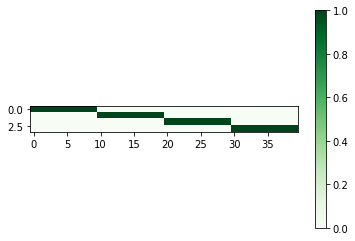

In [177]:
#z_min, z_max = -np.abs(labelmat).max(), np.abs(labelmat).max() 
a = plt.imshow(labelmat_c, cmap ='Greens') 
plt.colorbar(a) 

plt.show() 

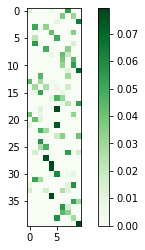

In [178]:
b = plt.imshow(C_c, cmap ='Greens') 
plt.colorbar(b) 

plt.show() 

Before training, the predicted label has nothing like the true grand truth label.

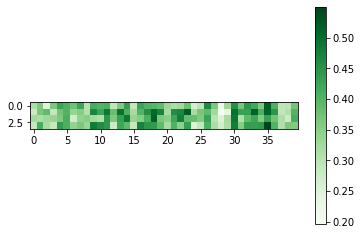

In [179]:
c = plt.imshow(labelmat_c @ C_c @ S_c, cmap ='Greens') 
plt.colorbar(c) 
  
#plt.title('matplotlib.pyplot.imshow() function Example',  
#                                     fontweight ="bold") 
plt.show() 

Double-check on the non-negativity of C_c

In [180]:
print(np.min(C_c))
print(np.min(labelmat_c @ C_c))

0.0
0.0


In [186]:
## helper code to reload changes on the "C_SSNMF" class method
del ssnmf
del C_SSNMF
import ssnmf 
from ssnmf import C_SSNMF

#### Training for C_SSNMF

Initialize model and check for initial losses

In [187]:
k = 10
model = C_SSNMF(X_c,k,Y = labelmat_c,lam=100*np.linalg.norm(X_c,'fro'),modelNum=1)

In [188]:
ini_error = model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm_c(model.Y, model.C, model.S, model.L)**2
acc = model.accuracy()
print("the initial relative reconstruction error is ", ini_error)
print("the initial classifier's accuracy is ", acc)

the initial relative reconstruction error is  960754725.2723006
the initial classifier's accuracy is  0.25


Run 10000 iters for training. May stop early based on the default tol 10^-4

In [189]:
N = 10000
[errs,reconerrs,classerrs,classaccs] = model.mult(numiters = N,saveerrs = True)

In [190]:
size = reconerrs.shape[0]
rel_error = reconerrs[size - 1]**2/(model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm_c(model.Y, model.C, model.S, model.L)**2)
acc = classaccs[size - 1]
print("number of iterations that this model runs: ", size)
print("the final relative reconstruction error is ", rel_error)
print("the final classifier's accuracy is ", acc)

number of iterations that this model runs:  1687
the final relative reconstruction error is  0.00025237395374217634
the final classifier's accuracy is  1.0


Visualize the error/accuracy after training, as well as the predicted label matrix and data matrix

Text(0.5, 1.0, 'classaccs')

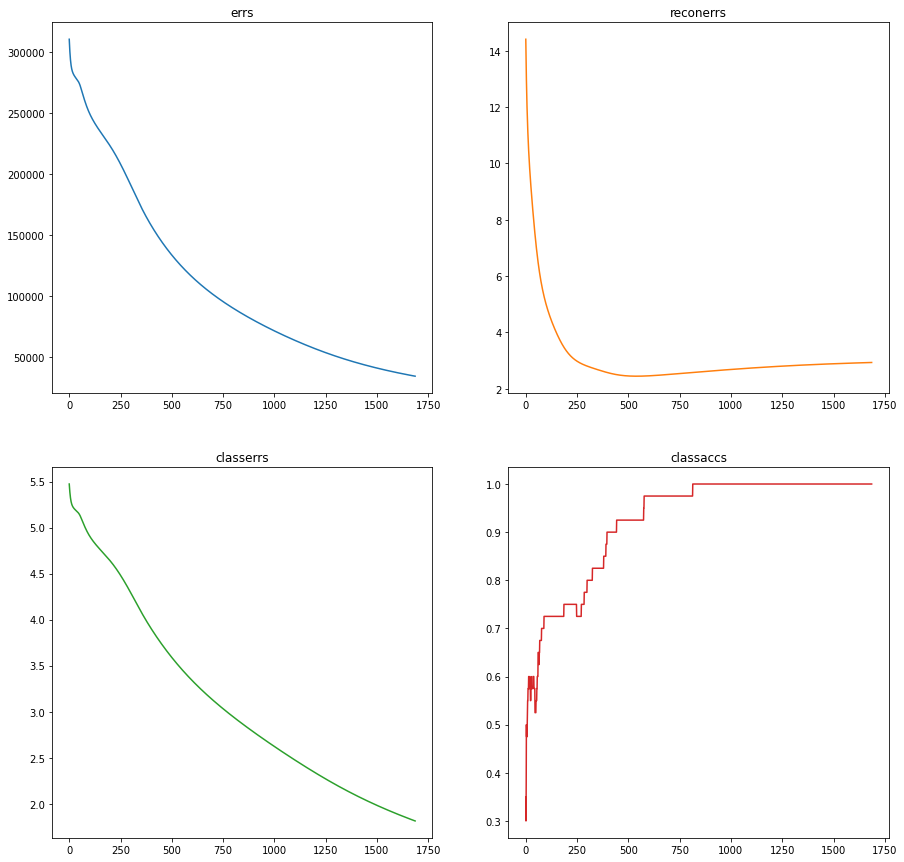

In [192]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0, 0].plot(range(0,1687), errs)
axs[0, 0].set_title('errs')
axs[0, 1].plot(range(0,1687), reconerrs, 'tab:orange')
axs[0, 1].set_title('reconerrs')
axs[1, 0].plot(range(0,1687), classerrs, 'tab:green')
axs[1, 0].set_title('classerrs')
axs[1, 1].plot(range(0,1687), classaccs, 'tab:red')
axs[1, 1].set_title('classaccs')

From the viz below we can see the estimated YCS looks similar to labelmat (gt Y). estimated AS looks similar to X_c

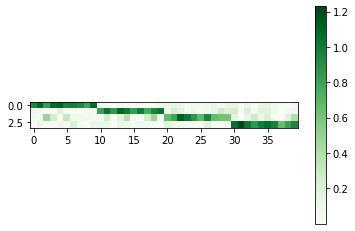

In [193]:
d = plt.imshow(model.Y @ model.C @ model.S,cmap = 'Greens')
plt.colorbar(d) 

plt.show() 

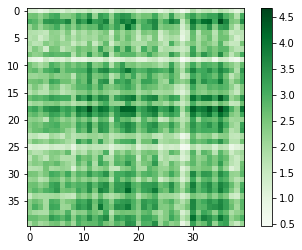

In [194]:
e = plt.imshow(model.A @ model.S,cmap = 'Greens')
plt.colorbar(e)

plt.show()

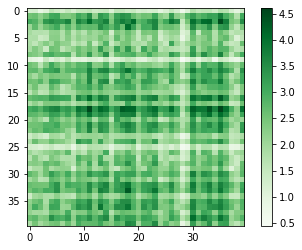

In [195]:
f = plt.imshow(X_c,cmap = 'Greens')
plt.colorbar(f)

plt.show()

From two viz's below we can see neither the column sum of C nor the column sum of Y @ C = 1. Future update needed

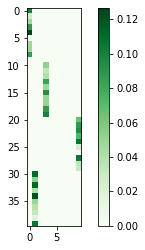

In [196]:
g = plt.imshow(model.C,cmap = 'Greens')
plt.colorbar(g)

plt.show()


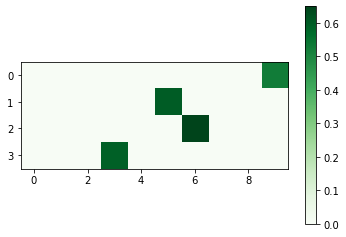

In [164]:
h = plt.imshow(model.Y @ model.C,cmap = 'Greens')
plt.colorbar(h)

plt.show()

#### Run a comparison test on SSNMF

In [197]:
from ssnmf import SSNMF_N
model2 = SSNMF_N(X_c,k,Y = labelmat_c,lam=100*np.linalg.norm(X_c,'fro'), modelNum = 3)

In [198]:
ini_error_ = model2.fronorm(model2.X, model2.A, model2.S, model2.W)**2 + model2.lam * model2.fronorm(model2.Y, model2.B, model2.S, model2.L)**2
acc_ = model2.accuracy()
print("the initial relative reconstruction error is ", ini_error_)
print("the initial classifier's accuracy is ", acc_)

the initial relative reconstruction error is  11436312.969568422
the initial classifier's accuracy is  0.275


In [199]:
N = 10000
[errs_,reconerrs_,classerrs_,classaccs_] = model2.mult(numiters = N,saveerrs = True)

In [200]:
size = reconerrs_.shape[0]
rel_error_ = reconerrs_[size - 1]**2/(model2.fronorm(model2.X, model2.A, model2.S, model2.W)**2 + model2.lam * model2.fronorm(model2.Y, model2.B, model2.S, model2.L)**2)
acc_ = classaccs_[size - 1]
print("number of iterations that this model runs: ", size)
print("the final relative reconstruction error is ", rel_error_)
print("the final classifier's accuracy is ", acc_)

number of iterations that this model runs:  19
the final relative reconstruction error is  0.6788087641731869
the final classifier's accuracy is  1.0


Text(0.5, 1.0, 'classaccs')

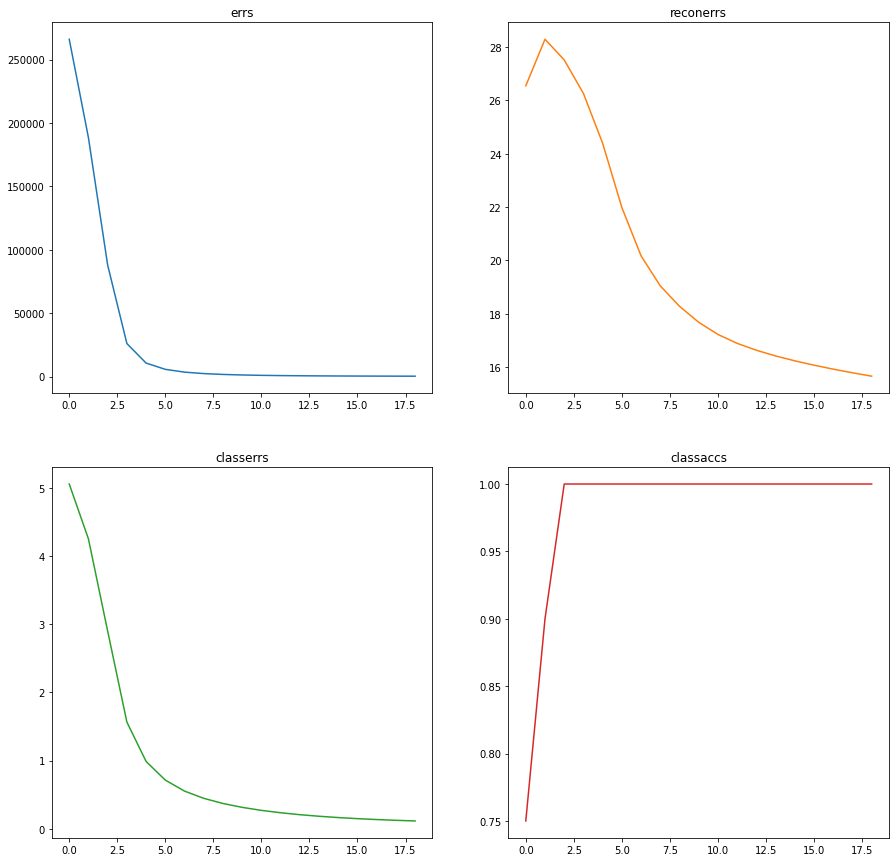

In [201]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0, 0].plot(range(0,19), errs_)
axs[0, 0].set_title('errs')
axs[0, 1].plot(range(0,19), reconerrs_, 'tab:orange')
axs[0, 1].set_title('reconerrs')
axs[1, 0].plot(range(0,19), classerrs_, 'tab:green')
axs[1, 0].set_title('classerrs')
axs[1, 1].plot(range(0,19), classaccs_, 'tab:red')
axs[1, 1].set_title('classaccs')

#### Future work for Kal and Cameron:

1. implement the remaining method under C_SSNMF. (Derive kl-divergence?)

2. implement the constraint that column of C (Y @ C) adds up to 1.

3. Look for real data that works better w/ the convexity constaint and run parallel comparison test on SSNMF.

4. Figure out the missing data matrix indicator

# IGNORE CELLS BELOW

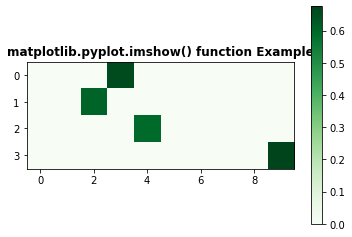

In [123]:
## Y @ C which factor is usefully as we perform deceomposition
## further @ S (S - coefficient of those useful factors) -> estimated label matrix
## we scale of C -> sum_col(Y @ C) -> 
##Y  [1 ,0,0,1 ,1,1,0,0,0,0] c [0.5,0.004,0,0.2996,0.1,0.1,0,0,0]
##   [0,1,1,0,0,0,1,1,1,1] c
## resale columns of Y @ C -> sum(columns) = 1 -> hold convexity 
## for equivalence-> scale down rows of S
## furthermore, we need to scale up rows of A by the same value to preserve the same X
b = plt.imshow(model.Y @ model.C, cmap ='Greens') 
plt.colorbar(b) 
  
plt.title('matplotlib.pyplot.imshow() function Example',  
                                     fontweight ="bold") 
plt.show() 

S is singular so I added random values between 0 and 1 to the entries. 

1. clustering based 
2. [S (S^TS)-1].T adopt this? 
Y = BS
B = YC 
C = diag()
Y = YCS
CS = I

In [41]:
C = np.transpose(S @ np.linalg.inv(np.transpose(S) @ S + np.random.random((40,40))))

In [114]:
labelmat = np.concatenate((np.concatenate((np.ones([1,10]),np.zeros([1,30])),axis=1),
                           np.concatenate((np.zeros([1,10]),np.ones([1,10]),np.zeros([1,20])),axis=1),
                           np.concatenate((np.zeros([1,20]),np.ones([1,10]),np.zeros([1,10])),axis=1),
                           np.concatenate((np.zeros([1,30]),np.ones([1,10])),axis=1)))
B = sparse.random(4,10,density=0.2).toarray()
S = np.zeros([10,40])

for i in range(40):
    S[:,i] = opt.nnls(B,labelmat[:,i])[0]
A = np.random.rand(40,10)
X = A @ S

In [115]:
ini_error = model.fronorm(model.X, model.A, model.S, model.W)**2 + model.lam * model.fronorm(model.Y, model.B, model.S, model.L)**2
acc = model.accuracy()
print("the initial relative reconstruction error is ", ini_error)
print("the initial classifier's accuracy is ", acc)

the initial relative reconstruction error is  7228540.376574316
the initial classifier's accuracy is  0.425


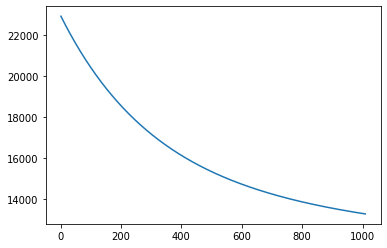

In [120]:
plt.plot(range(1,1010),errs)